In [1]:
from google.colab import drive #Connect colab to your drive
drive.mount('/content/drive', force_remount = True) #create a drive at /content/drive/MyDrive

Mounted at /content/drive


In [2]:
#import libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import scipy
import random
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [3]:
#load velocity data into the directory
D = np.loadtxt('/content/drive/MyDrive/icevelocity.txt')

(1) fit polynomial models of degree 0-4 to the velocity vs. depth data using polyfit. Evaluate the model at each measured depth using polyval. Plot the 5 model curves with the original data and state the root mean squared error in the legend.

In [4]:
# Define a function to calculate RMSE
def RMSE(predicted, actual):
    predicted = np.array(predicted)
    actual = np.array(actual)
    rmse = np.sqrt(np.nanmean((predicted - actual)**2))
    return rmse

RMSE for degree 0 polynomial: 5.09
RMSE for degree 1 polynomial: 2.70
RMSE for degree 2 polynomial: 1.89
RMSE for degree 3 polynomial: 1.73
RMSE for degree 4 polynomial: 1.73


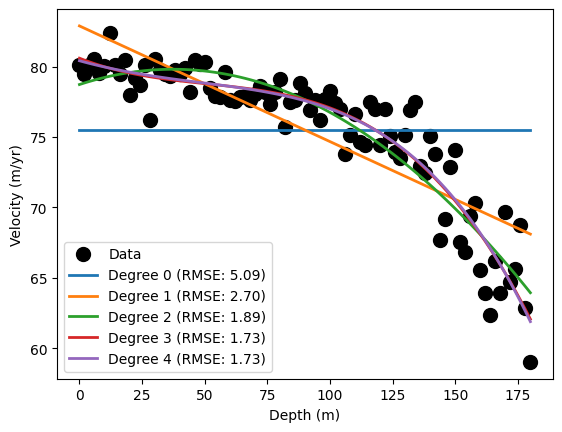

In [5]:
z = D[:, 0]  # Depth data
v = D[:, 1]  # Velocity data

# Fit polynomial models of degrees 0-4 and calculate RMSE for each
n = [0, 1, 2, 3, 4]
RMSE_values = []

for i in n:
    P = np.polyfit(z, v, i)  # Fit polynomial of degree i
    predicted_values = np.polyval(P, z)  # Get predicted values
    rmse = RMSE(predicted_values, v)  # Calculate RMSE
    RMSE_values.append(rmse)

    print(f"RMSE for degree {i} polynomial: {rmse:.2f}")

# Plot the data and the fitted polynomials
plt.figure(1)
plt.plot(z, v, 'ko', linewidth=2, markersize=10, label='Data')
plt.xlabel('Depth (m)')
plt.ylabel('Velocity (m/yr)')

for i, rmse in zip(n, RMSE_values):
    P = np.polyfit(z, v, i)
    plt.plot(z, np.polyval(P, z), linewidth=2, label=f'Degree {i} (RMSE: {rmse:.2f})')

plt.legend()
plt.show()

(2) provide estimates of uncertainties in model parameters by repeating the above and fit the models to a random sampling of 90% of the original data. store the parameters for each model and repeat 1000 times (Monte-carlo). Report the model parameters in a table using the mean and standard deviation of the 1000 parameter estimates.

In [6]:
#write a function for gettraintest
def getTrainTest(data, percenttrain): #percenttrain = percent of data wanted for training dataset (in decimal form)
  dim = np.shape(data)
  ns = dim[0] #ns = number of samples
  nd = dim[1] #nd = number of dimensions
  ns_train = round(percenttrain * ns) #nstrain = number of samples for training
  Ix = np.arange(ns) #Ix = vector of indicies
  IxTrain = random.sample(sorted(Ix), ns_train)
  trainset = data[IxTrain,:] # trainset = data for training
  Ix_test = [1]*len(Ix) #Ix_test = vector of 1s
  for i in range(len(IxTrain)):
    Ix_test[IxTrain[i]] = 0 #remove indicies to the training data
  Ix_test = np.where(Ix_test)[0]
  testset = data[Ix_test,:] #data for testing
  return trainset, testset

In [7]:
#get a random sampling of 90% of the original data
#random_dataset = getTrainTest(D, 0.9)

D_train, D_test = getTrainTest(D, 0.9)

#define the depth(z_random) and velocity(v_random) for the training dataset (90%)
z_train = D_train[:,0]
v_train = D_train[:,1]

#define the depth and velocity for the test dataset (10%)
z_test = D_test[:,0]
v_test = D_test[:,1]

In [8]:
n = [0,1,2,3,4]
RMSE_values = []
for i in n:
    P_train = np.polyfit(z_train, v_train, i)  # Fit polynomial of degree i
    predicted_values = np.polyval(P_train, z_train)  # Get predicted values
    rmse = RMSE(predicted_values, v_train)  # Calculate RMSE
    RMSE_values.append(rmse)

    print(f"RMSE for degree {i} polynomial: {rmse:.2f}")

RMSE for degree 0 polynomial: 5.13
RMSE for degree 1 polynomial: 2.76
RMSE for degree 2 polynomial: 1.93
RMSE for degree 3 polynomial: 1.74
RMSE for degree 4 polynomial: 1.74


In [9]:
#store the paramaters for each model and repeat 1000 times (Monte-Carlo)
#create variable for number of experiments
m = 1000

#define the sample size
n = 10

#create variables to store results
mean_samples = np.empty(shape=m)
std_samples = np.empty(shape=m)

for i in range (m):
  mean_samples[i] = np.random.choice(D_train.flatten(), size=n, replace=True).mean()
  std_samples[i] = np.random.choice(D_train.flatten(), size=n, replace=True).std()

In [10]:
# statistics of the variables sampled
mean_x_bar = mean_samples.mean()
std_x_bar = mean_samples.std()

mean_std = std_samples.mean()
std_std =std_samples.std()

print('the mean and st.dev of mean_samples are {:.6f} and {:.6f}'.format(mean_x_bar, std_x_bar))
print('the mean and st.dev of std_samples are {:.6f} and {:.6f}'.format(mean_std, std_std))

the mean and st.dev of mean_samples are 84.126920 and 12.038398
the mean and st.dev of std_samples are 34.474591 and 9.686733


In [11]:
#report the model parameters in a table
from os import stat
statistics_mean = ["mean", "standard deviation"]
values_mean = [mean_x_bar, mean_std]

table_mean = pd.DataFrame({"Statistics of mean of train data": statistics_mean, "Values": values_mean})
print(table_mean)

statistics_std = ["mean", "standard deviation"]
values_std = [mean_std, std_std]

table_std = pd.DataFrame({"Statistics of std of train data": statistics_std, "Values": values_std})
print(table_std)

  Statistics of mean of train data     Values
0                             mean  84.126920
1               standard deviation  34.474591
  Statistics of std of train data     Values
0                            mean  34.474591
1              standard deviation   9.686733


(3) perform a cross validation using 90% of the data to fit the 5 polynomial models and the remaining 10% to test, repeating 1000 times. plot the distribution of RMSE values for each degree polynomial

In [12]:
#use 10% of the data (testset) to test the 5 polynomial models and repeat 1000 times
testset = D_test

n = [0,1,2,3,4]
m = 1000

rmse_values = []

#calculate the rmse using the test data
for i in range(m):
  D_train, D_test = getTrainTest(D, 0.9)
  z_train = D_train[:,0]
  v_train = D_train[:,1]
  z_test = D_test[:,0]
  v_test = D_test[:,1]
  for j in range(len(n)):
  #fit degree j polynomial 1000 times
    P = np.polyfit(z_test, v_test, 0)
    predicted = np.polyval(P, z_test)
    rmse = RMSE(predicted, v_test)
    rmse_values.append(rmse)

rmse_deg0 = rmse_values[0:1000]
rmse_deg1 = rmse_values[1000:2000]
rmse_deg2 = rmse_values[2000:3000]
rmse_deg3 = rmse_values[3000:4000]
rmse_deg4 = rmse_values[4000:5000]


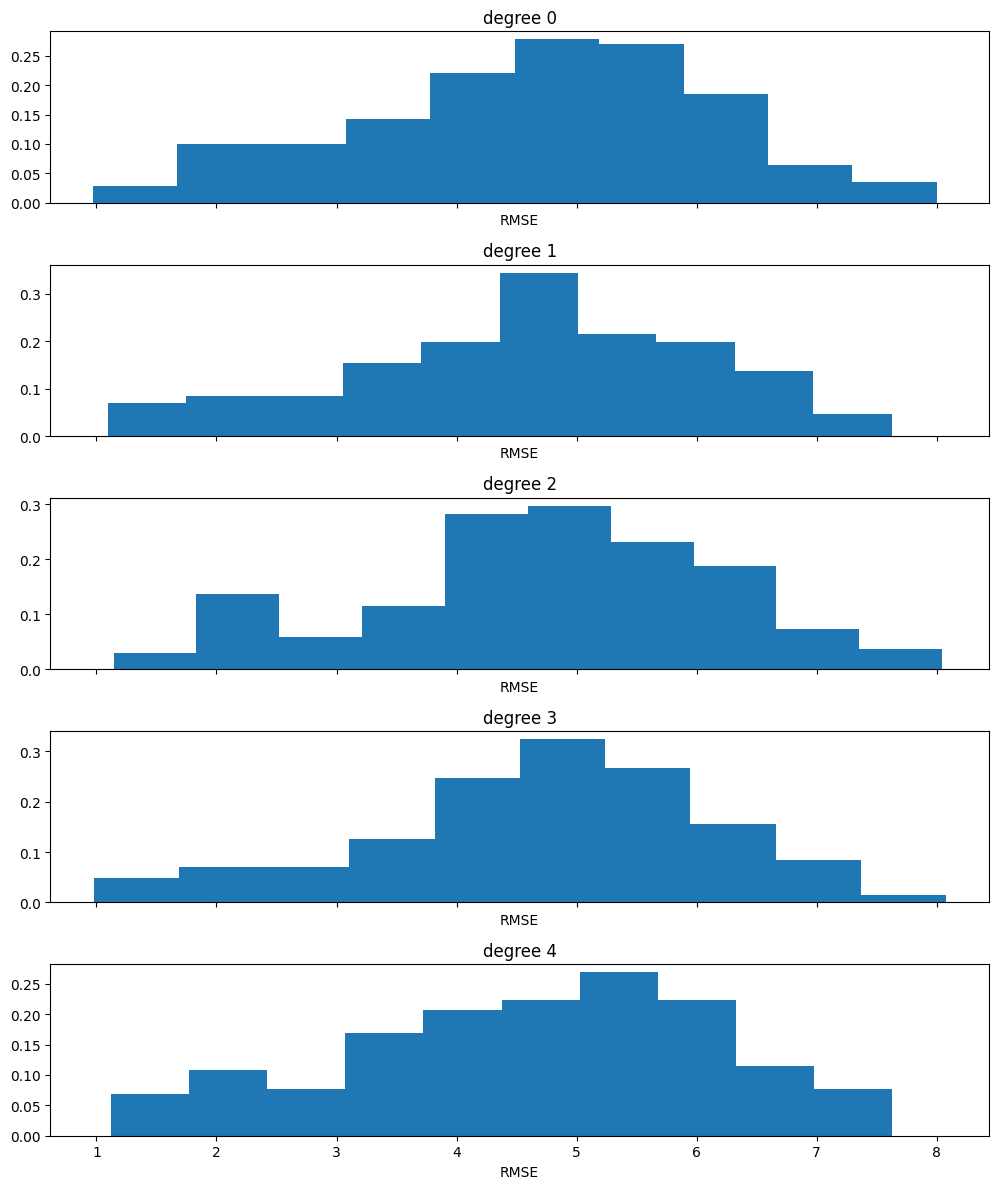

In [13]:
#plot the distribution of RMSE values for each degree polynomial
fig, ax = plt.subplots(5, figsize=(10, 12),sharex=True)

#degree 0
ax[0].hist(rmse_deg0, bins=10, density=True)
ax[0].set_title('degree 0')
ax[0].set_xlabel('RMSE')

#degree 1
ax[1].hist(rmse_deg1, bins=10,density=True)
ax[1].set_title('degree 1')
ax[1].set_xlabel('RMSE')

#degree 2
ax[2].hist(rmse_deg2, bins=10,density=True)
ax[2].set_title('degree 2')
ax[2].set_xlabel('RMSE')

#degree 3
ax[3].hist(rmse_deg3, bins=10,density=True)
ax[3].set_title('degree 3')
ax[3].set_xlabel('RMSE')

#degree 4
ax[4].hist(rmse_deg4, bins=10,density=True)
ax[4].set_title('degree 4')
ax[4].set_xlabel('RMSE')

plt.tight_layout()
plt.show()

(4) Use a moving window average to estimate the velocity as a function of depth and plot with the data for a window size of 3, 10, and 50 meters

(5) Repeat, using a weighted moving window average (non-parametric smooth), for a window size of 3,10, and 50 meters.

Text(0, 0.5, 'velocity (m/yr)')

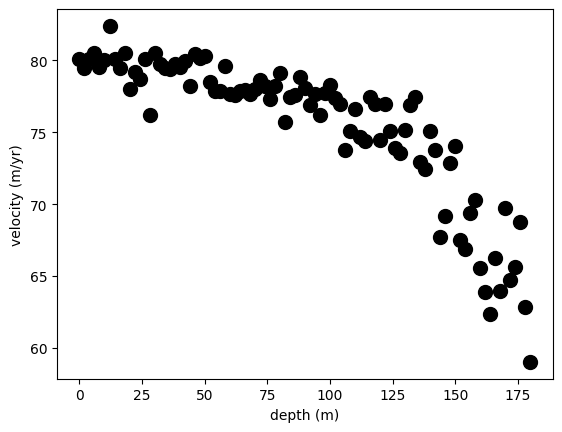

In [14]:
#plot of the original data
plt.figure(4)
plt.plot(z,v,'ko',linewidth=2,markersize=10)
plt.xlabel('depth (m)')
plt.ylabel('velocity (m/yr)')

In [15]:
def moving_window_average(depth, velocity, window_size, xmod):
  averaged_velocity = np.zeros(len(xmod))
  for i in range(len(xmod)):
    x_upper = xmod[i] + window_size/2
    x_lower = xmod[i] - window_size/2
    Ix = np.logical_and(depth<x_upper, depth>x_lower)
    points_in_window = velocity[Ix]
    averaged_velocity[i] = np.mean(points_in_window)
  return averaged_velocity

In [34]:
def weighted_window_average(depth, velocity, window_size, xmod):
  averaged_velocity = np.zeros(len(xmod))
  for i in range(len(xmod)):
    x_upper = xmod[i] + window_size/2
    x_lower = xmod[i] - window_size/2
    Ix = np.logical_and(depth<=x_upper, depth>=x_lower)
    weight = 0.9375*(1-(np.abs(depth[Ix]-xmod[i])/window_size)**2)**2
    #weight = 15/16 * (1-(dist[Ix]/window_size)**2)**2
    points_in_window = np.dot(velocity[Ix], weight)/np.sum(weight)
    averaged_velocity[i] = points_in_window
  return averaged_velocity

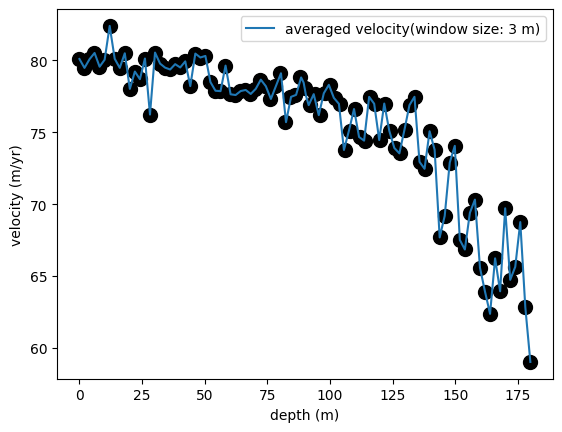

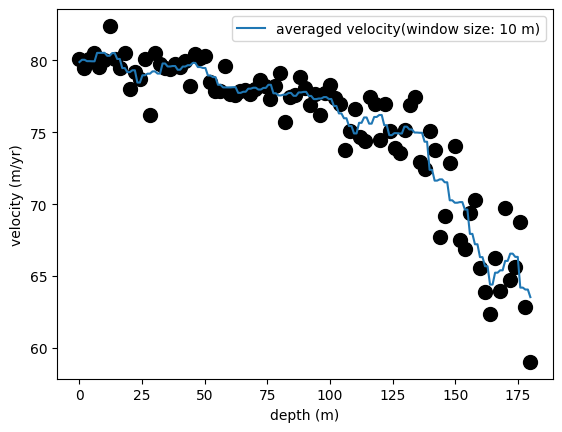

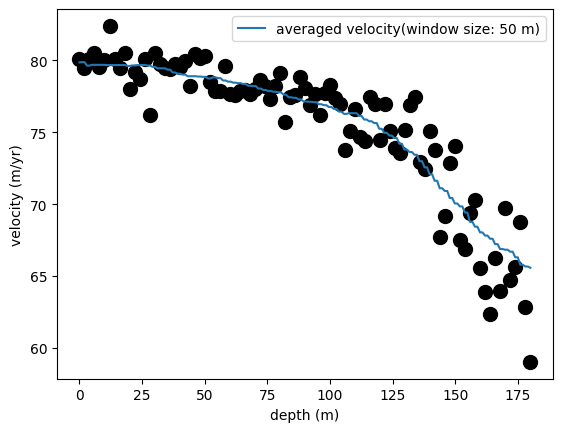

In [18]:
#plot the data for a window size of 3m, 10m, and 50m
plt.figure()

for window_size in [3,10,50]:
  plt.plot(z,v,'ko',linewidth=2,markersize=10)
  xmod = np.linspace(0,180,180)
  velocity_averaged = moving_window_average(z, v, window_size,xmod)
  plt.plot(xmod, velocity_averaged, label=f'averaged velocity(window size: {window_size} m)')
  plt.xlabel('depth (m)')
  plt.ylabel('velocity (m/yr)')
  plt.legend()
  plt.show()

(5) Use a weighted moving window average to estimate the velocity as a function of depth and plot with the data for a window of 3, 10, and 50 meters

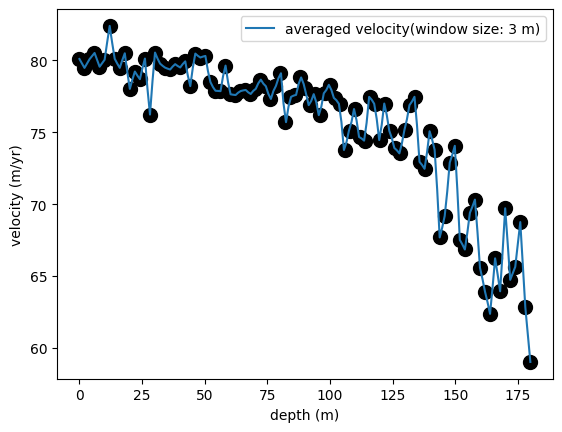

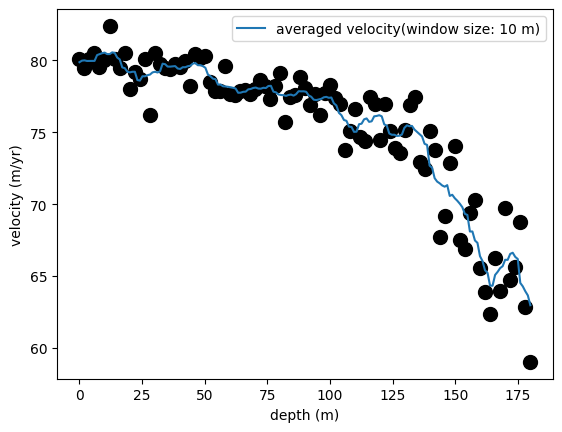

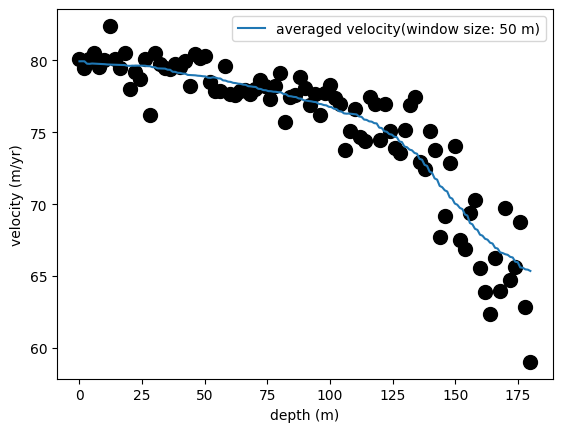

In [19]:
#plot the data for a window size of 3m, 10m, and 50m
plt.figure()

for window_size in [3,10,50]:
  plt.plot(z,v,'ko',linewidth=2,markersize=10)
  xmod = np.linspace(0,180,180)
  velocity_averaged_weighted = weighted_window_average(z, v, window_size, xmod)
  plt.plot(xmod, velocity_averaged_weighted, label=f'averaged velocity(window size: {window_size} m)')
  plt.xlabel('depth (m)')
  plt.ylabel('velocity (m/yr)')
  plt.legend()
  plt.show()

(6) Find the optimum window size for the weighted moving window average model.

In [47]:
#define a window size to test out
window_sizes = np.linspace(5,101,97)

#calculate the rmse for each window size
rmse_values = np.zeros((1000, len(window_sizes)))
xmod = np.linspace(0,180,91)
#create places to store results
ztest = np.zeros((9,1000))
vtest = np.zeros((9,1000))
ztrain = np.zeros((82,1000))
vtrain = np.zeros((82,1000))
for i in range(1000): #set up monte carlo
  D_train, D_test = getTrainTest(D, 0.9)
  ztrain[:,i] = D_train[:,0]
  vtrain[:,i] = D_train[:,1]
  ztest[:,i] = D_test[:,0]
  vtest[:,i] = D_test[:,1]

In [49]:
#monte carlo for all window sizes to get best values
for i in range(1000):
  for j in range(len(window_sizes)):
    vmod = weighted_window_average(ztrain[:,i], vtrain[:,i], window_sizes[j], ztest[:,i])
    rmse_values[i,j] = RMSE(vmod, vtest[:,i]) #compare modelled weighted window average with velocity test data

#plot rmse values vs window sizes
avg_rmse = np.zeros(len(window_sizes))
for i in range(len(window_sizes)):
  avg_rmse[i] = np.nanmean(rmse_values[:,i])

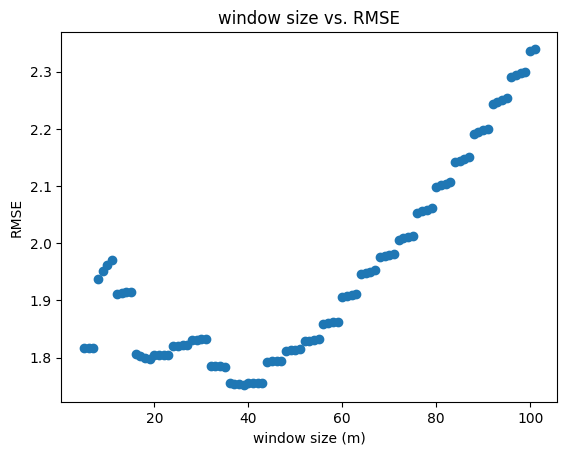

The optimum window size is [39.] m.


In [50]:
#plt.scatter(window_sizes, avg_rmse)
plt.scatter(window_sizes, avg_rmse)
plt.xlabel('window size (m)')
plt.ylabel('RMSE')
plt.title("window size vs. RMSE")
plt.show()

#find optimum window size
optimum_window_size = window_sizes[np.where(avg_rmse==np.nanmin(avg_rmse))]
print(f"The optimum window size is {optimum_window_size} m.")

(7) Using the measured velocity at a depth of z = 0 m for the surface velocity, u x,surf, find the optimum values for the flow law parameters A and n, using the grid search (brute-force) method.

(8) plot the RMSE as a function of A and n

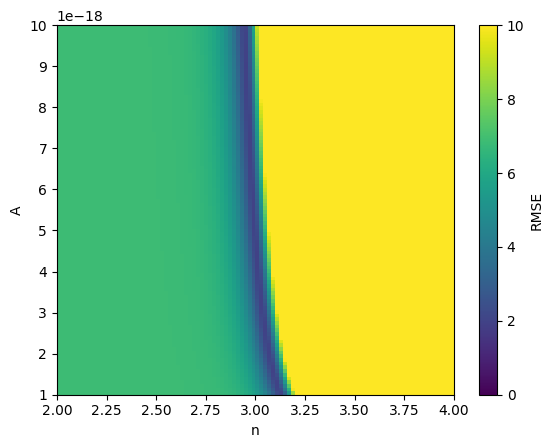

In [23]:
#function to calculate velocity
def velocity(A, n, Ux=80.086727):  #Ux = surface velocity
        return Ux - (A * (917 * 9.81 * np.sin(np.radians(10)))**n) * (z ** (n+1)) #unknowns = A and n

#define the ranges of A and n
A_range = np.linspace(1e-18, 10e-18, 100)
n_range = np.linspace(2, 4, 100)

#use brute force to find optimum values for A and n

Ux = 80.086727 #surface velocity = v at z=0

#create an empty array to store rmse
rmse = np.zeros((len(A_range), len(n_range)))

for j in range(len(n_range)):
  for i in range(len(A_range)):
    vmodel = velocity(A_range[i], n_range[j])
    rmse[i,j] = RMSE(vmodel,v)

#plot the rmse as a heatmap
plt.figure(5)
plt.imshow(rmse,extent=[n_range.min(), n_range.max(), A_range.min(), A_range.max()], aspect='auto',origin='lower',cmap='viridis',vmin=0, vmax=10)
plt.xlabel('n')
plt.ylabel('A')
plt.colorbar(label='RMSE')
#plt.plot()
plt.show()

(9) find the optimum values of A and n using the gradient search method

In [24]:
#gradient search
#use n=3 to simplify for the minimize function

def RMSEval(parameters):
  B = parameters
  n = 3
  vmodel = Ux - (B * z**(n+1))
  rmse = RMSE(vmodel,v)
  return rmse

initial_guess = [2e-8] #[5e-18 * (917 * 9.81 * np.sin(np.radians(10)))**3]
result = minimize(RMSEval, initial_guess)
pbest=result.x
print(f'best parameters: slope:{pbest[0]}')

A = pbest/((917 * 9.81 * np.sin(np.radians(10)))**3)
print(f'best parameters: A={A[0]:.6e}')

best parameters: slope:1.8252491620841413e-08
best parameters: A=4.788466e-18


(10) Randomly sample 90% of the dataset and find the optimum value of A using the gradient search method, and repeat 1000 times. Plot the distribution of A and the RMS error (over all depths) in the model using a relative density histogram.

In [25]:
#Find A using 90% of the data

#define the depth and velocity for the training dataset (90%)
z_train = D_train[:,0]
v_train = D_train[:,1]

#define the depth and velocity for the test dataset (10%)
z_test = D_test[:,0]
v_test = D_test[:,1]

#find A using the gradient search method
def RMSEval(parameters):
  B = parameters
  n = 3
  vmodel = Ux - (B * z_train**(n+1))
  rmse = RMSE(vmodel,v_train)
  return rmse

initial_guess = [2e-8] #[5e-18 * (917 * 9.81 * np.sin(np.radians(10)))**3]
result = minimize(RMSEval, initial_guess)
pbest=result.x
print(f'best parameters: slope:{pbest[0]}')

A = pbest/((917 * 9.81 * np.sin(np.radians(10)))**3)
print(f'best parameters: A={A[0]:.6e}')

best parameters: slope:1.8299445013089422e-08
best parameters: A=4.800784e-18


In [26]:
#repeat 1000 times
A_values = []
RMSE_values = []
m = 1000
initial_guess = [2e-8]

for i in range(m):
  D_train, D_test = getTrainTest(D, 0.9)
  z_train = D_train[:,0]
  v_train = D_train[:,1]
  result = minimize(RMSEval, initial_guess)
  RMSE_values.append(RMSEval(result.x))
  pbest=result.x
  A = pbest/((917 * 9.81 * np.sin(np.radians(10)))**3)
  A_values.append(A[0])


(array([0.13159966, 0.32899915, 0.52639864, 0.19739949, 0.32899915,
        0.78959796, 1.05279728, 1.38179642, 1.84239523, 3.15839183,
        3.15839183, 4.80338757, 5.32978621, 5.85618484, 7.36958093,
        8.48817803, 8.75137735, 6.6457828 , 4.2111891 , 1.44759625]),
 array([1.75532914, 1.77052675, 1.78572436, 1.80092197, 1.81611958,
        1.83131718, 1.84651479, 1.8617124 , 1.87691001, 1.89210761,
        1.90730522, 1.92250283, 1.93770044, 1.95289804, 1.96809565,
        1.98329326, 1.99849087, 2.01368848, 2.02888608, 2.04408369,
        2.0592813 ]),
 <BarContainer object of 20 artists>)

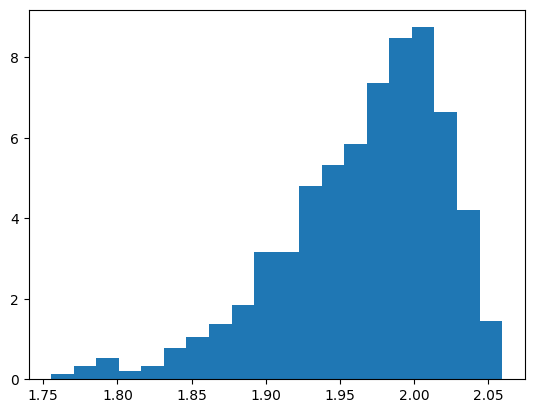

In [27]:
#plot distributions of RMSE on a histogram
plt.figure()
plt.hist(RMSE_values, bins=20, density=True)

(array([1.96309206e+17, 5.23491216e+17, 2.91191989e+18, 5.62753057e+18,
        9.71730569e+18, 6.02014898e+18, 3.69715671e+18, 2.48658327e+18,
        8.17955024e+17, 3.59900211e+17, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.59900211e+17]),
 array([4.63563744e-18, 4.66620147e-18, 4.69676550e-18, 4.72732952e-18,
        4.75789355e-18, 4.78845758e-18, 4.81902161e-18, 4.84958563e-18,
        4.88014966e-18, 4.91071369e-18, 4.94127772e-18, 4.97184174e-18,
        5.00240577e-18, 5.03296980e-18, 5.06353383e-18, 5.09409786e-18,
        5.12466188e-18, 5.15522591e-18, 5.18578994e-18, 5.21635397e-18,
        5.24691799e-18]),
 <BarContainer object of 20 artists>)

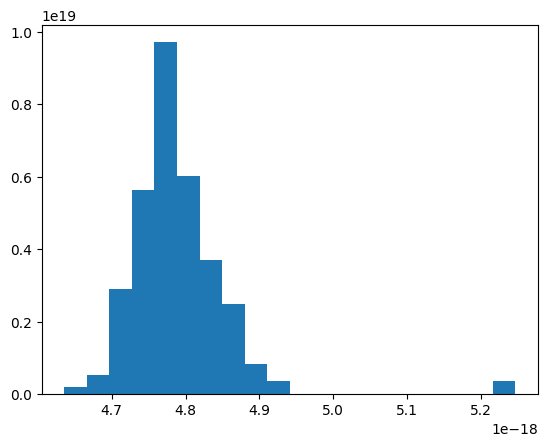

In [28]:
#plot distributions of A on a histogram
plt.figure()
plt.hist(A_values, bins=20, density=True)

(11)Plot the mean optimum values of A and its standard deviation with vertical errorbars on your figure from #7.

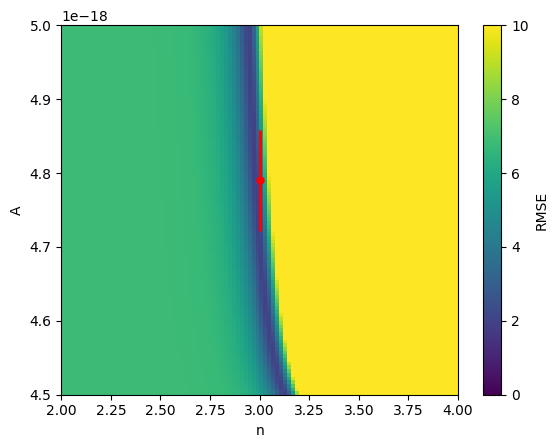

In [29]:
#function to calculate velocity
def velocity(A, n, Ux=80.086727):  #Ux = surface velocity
        return Ux - (A * (917 * 9.81 * np.sin(np.radians(10)))**n) * (z ** (n+1)) #unknowns = A and n

#define the ranges of A and n
A_range = np.linspace(1e-18, 10e-18, 100)
n_range = np.linspace(2, 4, 100)

#use brute force to find optimum values for A and n

Ux = 80.086727 #surface velocity = v at z=0

#create an empty array to store rmse
rmse = np.zeros((len(A_range), len(n_range)))

for j in range(len(n_range)):
  for i in range(len(A_range)):
    vmodel = velocity(A_range[i], n_range[j])
    rmse[i,j] = RMSE(vmodel,v)

A_avg = np.mean(A_values)
A_std = np.std(A_values)

n=3

#plot the rmse as a heatmap with optimum value of A
plt.figure()
plt.imshow(rmse,extent=[n_range.min(), n_range.max(), 4.5e-18, 5e-18], aspect='auto',origin='lower',cmap='viridis',vmin=0, vmax=10)
plt.xlabel('n')
plt.ylabel('A')
plt.colorbar(label='RMSE')
plt.plot(n,A_avg,'ro',linewidth=2,markersize=5,label=f'gradient descent')
plt.errorbar(n, A_avg, yerr=A_std, fmt = 'r', linewidth=2, markersize=10, barsabove=True)
#plt.plot()
plt.show()

(12) For each of A and model RMS error, use the normal distribution model to generate 1000 simulated values with the mean and standard deviations from your Monte-Carlo simulations.

In [30]:
A_mean = np.mean(A_values)
A_std = np.std(A_values)

RMSE_mean = np.mean(RMSE_values)
RMSE_std = np.std(RMSE_values)

A_simulated = np.random.normal(loc=A_mean, scale=A_std, size=1000)
RMSE_simulated = np.random.normal(loc=RMSE_mean, scale=RMSE_std, size=1000)

(13) Use MATLAB’s kstest2 function to compare the actual distributions from your Monte-carlo parameter fitting (#9), with those simulated assuming a normal distribution (#11).

In [31]:
#Compare A[0] and pbest[0] with A_simulated and RMSE_simulated using kstest
from scipy.stats import kstest
kstest(A[0], A_simulated)

KstestResult(statistic=0.821, pvalue=0.35964035964035923, statistic_location=4.722880309488361e-18, statistic_sign=1)

In [32]:
kstest(pbest[0], RMSE_simulated)

KstestResult(statistic=1.0, pvalue=0.0019980019980019967, statistic_location=1.8002493330977426e-08, statistic_sign=1)